In [20]:
#1
# Step 1: Import the necessary libraries
# Main script used for loading the raw dataset and preparing it for the models.

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
os.environ["LOKY_MAX_CPU_COUNT"] = "4"   # or 2 if you prefer


DATAFILE = "attribute_dataset.csv"

In [21]:
#2
# Step 2: Load the dataset and verify that the file exists.

try:
    df = pd.read_csv(DATAFILE, dtype=str)   # read everything as string so cleaning is consistent
    print("Loaded dataset:", DATAFILE)
    print("Shape:", df.shape)
except FileNotFoundError:
    raise FileNotFoundError(
        f"Cannot find '{DATAFILE}'. Please make sure the file is in the working directory."
    )

Loaded dataset: attribute_dataset.csv
Shape: (479, 13)


In [22]:
#3
# Step 3: Convert all common missing-value markers into proper NaN values.

missing_markers = ["null", "NULL", "NaN", "nan", "NaT", "", " ", "None"]
df = df.replace(missing_markers, np.nan)

print("\nSTEP 1 DONE: Converted common textual nulls to NaN")
print("Missing values per column (after normalization):")
print(df.isnull().sum())



STEP 1 DONE: Converted common textual nulls to NaN
Missing values per column (after normalization):
Dress_ID            0
Style               0
Price               2
Rating              0
Size                0
Season              2
NeckLine            3
SleeveLength        2
Material          119
FabricType        256
Decoration        224
Pattern Type      102
Recommendation      0
dtype: int64


In [23]:
#4
# Step 4: Basic type corrections and initial inspections.

# Clean all string columns by stripping extra spaces
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype(str).str.strip()

# Convert the Rating column into a numeric type
if "Rating" in df.columns:
    df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

print("\nSTEP 2 DONE: Normalized text fields and converted Rating to numeric")
print(df.dtypes)
print("Rating stats (after conversion):")
print(df["Rating"].describe())


STEP 2 DONE: Normalized text fields and converted Rating to numeric
Dress_ID           object
Style              object
Price              object
Rating            float64
Size               object
Season             object
NeckLine           object
SleeveLength       object
Material           object
FabricType         object
Decoration         object
Pattern Type       object
Recommendation     object
dtype: object
Rating stats (after conversion):
count    479.000000
mean       3.489353
std        2.028941
min        0.000000
25%        2.000000
50%        4.600000
75%        4.800000
max        5.000000
Name: Rating, dtype: float64


In [24]:
#5
# Step 5: Fill missing categorical values and handle numeric gaps.

# Identify categorical columns (everything except numeric fields and ID columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
id_cols = [c for c in df.columns if c.lower().startswith("dress_id")]
cat_cols = [c for c in df.columns if c not in numeric_cols + id_cols]

# Replace missing values in categorical fields
df[cat_cols] = df[cat_cols].fillna("Unknown")

# Handle missing values in Rating by replacing NaN with the median
if "Rating" in df.columns:
    rating_na = df["Rating"].isnull().sum()
    if rating_na > 0:
        median_rating = df["Rating"].median()
        df["Rating"] = df["Rating"].fillna(median_rating)
        print(f"\nSTEP 3: Filled {rating_na} missing Rating values with median = {median_rating}")

print("\nSTEP 3 DONE: Categorical and numeric missing values addressed")
print("Missing counts now:")
print(df.isnull().sum())


STEP 3 DONE: Categorical and numeric missing values addressed
Missing counts now:
Dress_ID          0
Style             0
Price             0
Rating            0
Size              0
Season            0
NeckLine          0
SleeveLength      0
Material          0
FabricType        0
Decoration        0
Pattern Type      0
Recommendation    0
dtype: int64


In [25]:
#6
# Step 6: Correct common typos and bring categorical values to a consistent format.

# Standardize all categorical text by lowercasing and trimming spaces
for c in cat_cols:
    df[c] = df[c].astype(str).str.lower().str.strip()

# Common typo corrections observed in the dataset
typo_map = {
    "sleevless": "sleeveless",
    "automn": "autumn",
    "polyster": "polyester",
    "polysteric": "polyester",
    "shiffon": "chiffon",
    "chiffonfabric": "chiffon",
    "thressqatar": "threequarter",
    "threeqatar": "threequarter",
    "milksilk": "milksilk",
    "o-neck": "o-neck"
}

# Apply corrections across all categorical columns
for col in cat_cols:
    df[col] = df[col].replace(typo_map)

# Normalize price categories into a smaller, unified set
if "Price" in df.columns:
    df["Price"] = df["Price"].replace({
        "very-high": "very high",
        "veryhigh": "very high",
        "medium": "average",
        "high": "high",
        "average": "average",
        "low": "low"
    })

print("\nSTEP 4 DONE: Corrected typos and standardized category groups.")
print("Sample unique values (first few from each column):")
for c in cat_cols:
    print(f" - {c}: {df[c].unique()[:8]}")


STEP 4 DONE: Corrected typos and standardized category groups.
Sample unique values (first few from each column):
 - Style: ['sexy' 'casual' 'vintage' 'brief' 'cute' 'bohemian' 'flare' 'party']
 - Price: ['low' 'high' 'average' 'very high' 'nan']
 - Size: ['m' 'l' 'xl' 'free' 's' 'small']
 - Season: ['summer' 'autumn' 'spring' 'winter' 'nan']
 - NeckLine: ['o-neck' 'v-neck' 'boat-neck' 'peterpan-collor' 'ruffled'
 'turndowncollor' 'slash-neck' 'mandarin-collor']
 - SleeveLength: ['sleeveless' 'petal' 'full' 'butterfly' 'short' 'threequarter'
 'halfsleeve' 'cap-sleeves']
 - Material: ['nan' 'microfiber' 'polyester' 'silk' 'chiffon' 'cotton' 'nylon' 'other']
 - FabricType: ['chiffon' 'nan' 'broadcloth' 'jersey' 'other' 'batik' 'satin' 'flannael']
 - Decoration: ['ruffles' 'nan' 'embroidary' 'bow' 'beading' 'lace' 'sashes' 'hollowout']
 - Pattern Type: ['animal' 'print' 'dot' 'solid' 'nan' 'patchwork' 'striped' 'geometric']
 - Recommendation: ['1' '0']


In [26]:
#7
# Step 7: Encode categorical values and scale numeric features.

# Decide which columns belong to numeric and categorical groups
final_numeric = ["Rating"] if "Rating" in df.columns else []
final_categorical = [c for c in cat_cols if c not in id_cols]

# Build the transformation pipeline
transformers = []

# Encode categorical columns using one hot encoding
if final_categorical:
    transformers.append(
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), final_categorical)
    )

# Scale numeric columns
if final_numeric:
    transformers.append(("num", StandardScaler(), final_numeric))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

# Prepare the feature matrix
X = df[[*final_categorical, *final_numeric]] if (final_categorical or final_numeric) else pd.DataFrame()

# Fit the transformation pipeline on the dataset
if not X.empty:
    preprocessor.fit(X)
    print("\nSTEP 5: Preprocessing pipeline fitted on current data.")
else:
    print("\nSTEP 5: No features to preprocess.")

# Save the preprocessing pipeline to file
joblib.dump(preprocessor, "preprocessing_pipeline.pkl")
print("Saved preprocessing pipeline to 'preprocessing_pipeline.pkl'")

# Apply preprocessing and build the processed DataFrame
if not X.empty:
    X_trans = preprocessor.transform(X)

    feature_names = []

    # Build feature name list for encoded categorical columns
    if final_categorical:
        cat_encoder = preprocessor.named_transformers_["cat"]
        cat_names = cat_encoder.get_feature_names_out(final_categorical).tolist()
        feature_names.extend(cat_names)

    # Add numeric column names
    if final_numeric:
        feature_names.extend(final_numeric)

    processed_df = pd.DataFrame(X_trans, columns=feature_names, index=df.index)

    # Add target column if present
    if "Recommendation" in df.columns:
        processed_df["Recommendation"] = df["Recommendation"].astype(int)

    print("STEP 5 DONE: Created processed DataFrame.")
else:
    processed_df = df.copy()


STEP 5: Preprocessing pipeline fitted on current data.
Saved preprocessing pipeline to 'preprocessing_pipeline.pkl'
STEP 5 DONE: Created processed DataFrame.


In [27]:
#8
# Step 8: Create a train-test split and save all cleaned files.

# Perform a stratified split if the target column exists
if "Recommendation" in df.columns:
    df["Recommendation"] = df["Recommendation"].astype(int)
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["Recommendation"]
    )
else:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# File names for saving outputs
clean_filename = "attribute_dataset_cleaned.csv"
train_filename = "train.csv"
test_filename = "test.csv"

# Save the full cleaned dataset and both splits
df.to_csv(clean_filename, index=False)
train_df.to_csv(train_filename, index=False)
test_df.to_csv(test_filename, index=False)

print("\nSTEP 6 DONE: Train-test split created and files saved:")
print(" - Full cleaned:", clean_filename)
print(" - Train:", train_filename)
print(" - Test:", test_filename)


STEP 6 DONE: Train-test split created and files saved:
 - Full cleaned: attribute_dataset_cleaned.csv
 - Train: train.csv
 - Test: test.csv


In [28]:
#9
# Final summary of the cleaning pipeline.

print("\nCLEANING PIPELINE COMPLETE. Summary:")
print("Original shape:", pd.read_csv(DATAFILE).shape)
print("Cleaned shape:", df.shape)
print("You can now start modelling using 'train.csv' and 'test.csv'.")


CLEANING PIPELINE COMPLETE. Summary:
Original shape: (479, 13)
Cleaned shape: (479, 13)
You can now start modelling using 'train.csv' and 'test.csv'.


In [29]:
#10
import pandas as pd

# Load the cleaned dataset produced by the pipeline
df = pd.read_csv("attribute_dataset_cleaned.csv", dtype=str)

# Normalize text columns for easier inspection
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).str.strip().str.lower()

# Columns chosen for checking category distributions
cat_cols = [
    "Style", "Price", "Size", "Season", "neckline",
    "SleeveLength", "Material", "FabricType",
    "Decoration", "Pattern Type"
]

# Display the most common categories for each column
for c in cat_cols:
    if c in df.columns:
        vals = df[c].value_counts(dropna=False).head(30)
        print(f"\n--- {c} (unique={df[c].nunique()}) ---")
        print(vals)
    else:
        print(f"\n--- {c} not in dataframe ---")



--- Style (unique=12) ---
Style
casual      219
sexy         73
party        51
cute         44
vintage      25
bohemian     23
brief        17
work         17
novelty       6
flare         2
ol            1
fashion       1
Name: count, dtype: int64

--- Price (unique=5) ---
Price
average      270
low          165
high          21
very high     21
nan            2
Name: count, dtype: int64

--- Size (unique=6) ---
Size
m        171
free     165
l         93
s         35
xl        14
small      1
Name: count, dtype: int64

--- Season (unique=5) ---
Season
summer    154
winter    139
spring    118
autumn     66
nan         2
Name: count, dtype: int64

--- neckline not in dataframe ---

--- SleeveLength (unique=16) ---
SleeveLength
sleeveless        220
full               94
short              92
halfsleeve         32
threequarter       25
capsleeves          3
cap-sleeves         2
sleeevless          2
nan                 2
petal               1
butterfly           1
turndowncollor    

In [30]:
#11

import pandas as pd

# Step 0 — Load the cleaned dataset and normalize column names
df = pd.read_csv("attribute_dataset_cleaned.csv", dtype=str)

print("Loaded file: attribute_dataset_cleaned.csv")
print("Initial shape:", df.shape)

df.columns = df.columns.str.strip().str.lower()

# Step 1 — Normalize casing and trim whitespace in all values
for col in df.columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
    )

print("\nSTEP 1 DONE: Lowercased and trimmed values.")
print(df.head(3))

# Step 2 — Define typo corrections and category merging rules
typo_map = {
    "sleeevless": "sleeveless",
    "sleveless": "sleeveless",
    "sleevless": "sleeveless",
    "threequater": "threequarter",
    "threeqatar": "threequarter",
    "threeqatar sleeve": "threequarter",
    "urndowncollor": "unknown",
    "turndowncollor": "unknown",
    "polyster": "polyester",
    "polysteric": "polyester",
    "sill": "silk",
    "model": "modal",
    "viscos": "viscose",
    "wollen": "woolen",
    "sattin": "satin",
    "flannael": "flannel",
    "embroidary": "embroidery",
    "leapord": "leopard",
    "automn": "autumn",
    "very-high": "very high",
    "veryhigh": "very high",
    "medium": "average"
}

print("\nSTEP 2 READY: Typo map defined.")

# Step 3 — Apply corrections across all text columns
for col in df.columns:
    df[col] = df[col].replace(typo_map)

print("\nSTEP 3 DONE: Applied typo and synonym corrections.")
preview_cols = ["sleevelength", "material", "fabrictype", "decoration", "pattern type"]
existing_preview_cols = [c for c in preview_cols if c in df.columns]
print(df[existing_preview_cols].head())

# Step 4 — Standardize null-equivalent values
null_equivalents = ["nan", "none", "null", ""]

for col in df.columns:
    df[col] = df[col].replace(null_equivalents, "unknown")

print("\nSTEP 4 DONE: Null-equivalent values standardized.")

# Step 5 — Save the final normalized dataset
output_file = "attribute_dataset_normalized.csv"
df.to_csv(output_file, index=False)

print("\nSTEP 5 DONE: Saved normalized file:", output_file)
print("Final shape:", df.shape)
print("\nPreview:")
print(df.head(5))

Loaded file: attribute_dataset_cleaned.csv
Initial shape: (479, 13)

STEP 1 DONE: Lowercased and trimmed values.
     dress_id    style price rating size  season neckline sleevelength  \
0  1006032852     sexy   low    4.6    m  summer   o-neck   sleeveless   
1  1212192089   casual   low    0.0    l  summer   o-neck        petal   
2  1190380701  vintage  high    0.0    l  autumn   o-neck         full   

     material fabrictype decoration pattern type recommendation  
0         nan    chiffon    ruffles       animal              1  
1  microfiber        nan    ruffles       animal              0  
2   polyester        nan        nan        print              0  

STEP 2 READY: Typo map defined.

STEP 3 DONE: Applied typo and synonym corrections.
  sleevelength    material fabrictype  decoration pattern type
0   sleeveless         nan    chiffon     ruffles       animal
1        petal  microfiber        nan     ruffles       animal
2         full   polyester        nan         nan   

In [31]:
#12
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import joblib

# Load the fully normalized dataset
df = pd.read_csv("attribute_dataset_normalized.csv")
print("Loaded normalized dataset. Shape:", df.shape)

# Separate features from the target column
X = df.drop("recommendation", axis=1)
y = df["recommendation"].astype(int)

# Identify numeric and categorical feature columns
numeric_cols = ["rating"] if "rating" in X.columns else []
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Build the preprocessing pipeline for scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ]
)

# Create train-test split before fitting the processor
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit the processor using only the training data
preprocessor.fit(X_train)

# Apply the transformations
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("TRAIN processed shape:", X_train_processed.shape)
print("TEST processed shape:", X_test_processed.shape)

# Save processor and processed datasets
joblib.dump(preprocessor, "preprocessor.pkl")

pd.DataFrame(X_train_processed).to_csv("X_train_processed.csv", index=False)
pd.DataFrame(X_test_processed).to_csv("X_test_processed.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("All preprocessed files saved successfully.")

Loaded normalized dataset. Shape: (479, 13)
Numeric columns: ['rating']
Categorical columns: ['dress_id', 'style', 'price', 'size', 'season', 'neckline', 'sleevelength', 'material', 'fabrictype', 'decoration', 'pattern type']
TRAIN processed shape: (383, 504)
TEST processed shape: (96, 504)
All preprocessed files saved successfully.


In [32]:
#13
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"


# Load the processed training and testing sets
X_train = pd.read_csv("X_train_processed.csv")
X_test = pd.read_csv("X_test_processed.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Define the three models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}

# Train each model and evaluate performance on the test set
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.pkl")

# Print the metrics for each model
for model_name, metrics in results.items():
    print("\n========================")
    print(model_name)
    print("========================")
    print("Accuracy:", metrics["Accuracy"])
    print("Precision:", metrics["Precision"])
    print("Recall:", metrics["Recall"])
    print("F1 Score:", metrics["F1 Score"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])


Logistic Regression
Accuracy: 0.6875
Precision: 0.6774193548387096
Recall: 0.5121951219512195
F1 Score: 0.5833333333333334
Confusion Matrix:
 [[45 10]
 [20 21]]

Decision Tree
Accuracy: 0.5104166666666666
Precision: 0.42857142857142855
Recall: 0.43902439024390244
F1 Score: 0.43373493975903615
Confusion Matrix:
 [[31 24]
 [23 18]]

KNN
Accuracy: 0.6354166666666666
Precision: 0.5833333333333334
Recall: 0.5121951219512195
F1 Score: 0.5454545454545454
Confusion Matrix:
 [[40 15]
 [20 21]]


In [19]:
#14
import pandas as pd

# Create a comparison table from the stored results
comparison = pd.DataFrame(results).T[["Accuracy", "Precision", "Recall", "F1 Score"]]
comparison

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.6875,0.677419,0.512195,0.583333
Decision Tree,0.510417,0.428571,0.439024,0.433735
KNN,0.635417,0.583333,0.512195,0.545455


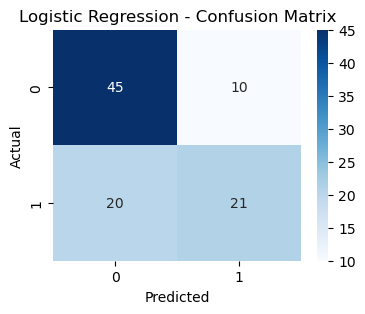

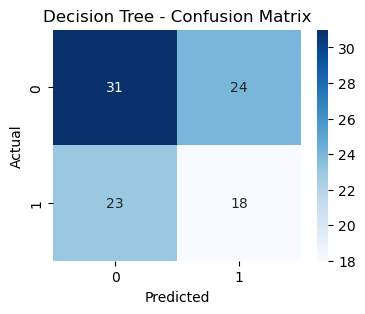

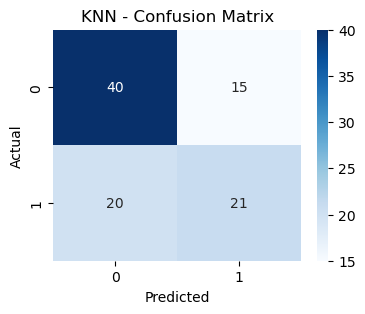

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

for model_name, metrics in results.items():
    cm = metrics["Confusion Matrix"]
    
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
